<a href="https://colab.research.google.com/github/rbdus0715/Natural-Language-Processing/blob/main/Lab-0%20deep_learning_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **신경망 복습** 
    - 신경망 추론
    - 학습

- 신경망 추론

In [1]:
# 선형
import numpy as np
W1 = np.random.randn(2,4)
b1 = np.random.randn(4)
x = np.random.randn(10,2)
h = np.matmul(x, W1) + b1

In [2]:
# 비선형, 활성화 함수
def sigmoid(x):
    return 1/ (1+np.exp(-x))
a = sigmoid(h)

In [3]:
# 신경망
x = np.random.randn(10,2)
W1 = np.random.randn(2,4)
b1 = np.random.randn(4)
W2 = np.random.randn(4,3)
b2 = np.random.randn(3)

h = np.matmul(x, W1) + b1
a = sigmoid(h)
s = np.matmul(a, W2) + b2

In [4]:
# 계층을 클래스로 구현
# 모든 계층은 forward, backward 메서드를 가짐

# sigmoid 클래스
class Sigmoid():
    def __init__(self):
        self.params = [] # 학습하는 매개변수가 없으므로 빈 리스트로 초기화
    
    def forward(self, x):
        return 1/(1+np.exp(-x))

# Affine 클래스
class Affine:
    def __init__(self, W, b):
        self.params = [W, b] # 학습하는 매개변수
    
    def forward(self, x):
        W, b = self.params
        out = np.matmul(x, W) + b
        return out

# 2층 레이어 신경망
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 가중치 편향 초기화
        W1 = np.random.randn(I, H)
        b1 = np.random.randn(H)
        W2 = np.random.randn(H, O)
        b2 = np.random.randn(O)

        # 계층 생성
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]

        # 모든 가중치를 리스트에 모음
        self.params = []
        for layer in self.layers:
            self.params += layer.params

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

In [5]:
x = np.random.randn(10, 2)
model = TwoLayerNet(2,4,3)
s = model.predict(x)

- 학습

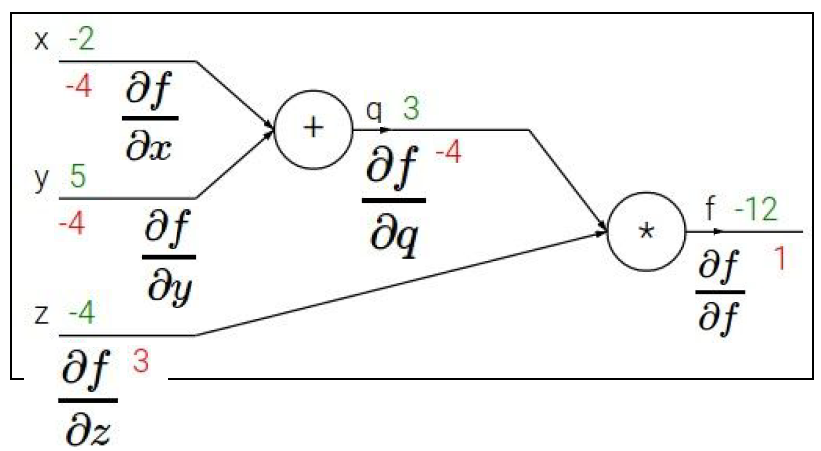

In [6]:
# 곱셈 노드 (input : x, y)
# x에서의 미분값
# 부모 신경망 미분값 * y

# 분기 노드
# 부모 신경망의 2배

# repeat 노드
# N개로의 분기
D, N = 8, 7
x = np.random.randn(1, D)               # 입력
y = np.repeat(x, N, axis=0)             # 순전파
dy = np.random.randn(N, D)              # 무작위 기울기
dx = np.sum(dy, axis=0, keepdims=True)  # 역전파

# sum 노드
D, N = 8, 7
x = np.random.randn(N, D)               # 입력
y = np.sum(x, axis=0, keepdims=True)    # 순전파
dy = np.random.randn(1, D)              # 무작위 기울기
dx = np.repeat(dy, N, axis=0)           # 역전파

# MatMul 노드
# dL/dx = dL/dy * wT
# dL/dw = xT * dL/dy
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.matmul(x, W)
        self.x = x
        return out

    def backward(self, dout): # dout : 이전 미분 넘겨 받음
        W, = self.params
        dx = np.matmal(dout, W.T)
        dW = np.matmul(self.x.T, dout)
        self.grads[0][...] = dW 
        # 생략 기호 : 넘파이 배열이 가리키는 메모리 위치를 고정, 그 위치에 원소들을 덮어씀
        # 깊은 복사 : grads[0][...] = dW
        # 얇은 복사 : grads[0] = dW
        return dx

In [8]:
# 기울기 도출과 역전파 구현
# sigoid, affine, softmax with loss

# Sigmoid 클래스
class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = N

    def forward(self, x):
        out = 1/(1+np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout*(1.0-self.out)*self.out
        return dx  

# Affine 클래스
class Affine:
    def __init__(self, W, b):
        self.params = [W, b] # 학습하는 매개변수
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.matmul(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        # matmul과 repeat 노드 역전파
        W, b = self.params
        dx = np.matmul(dout, W.T)
        dW = np.matmul(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

In [12]:
# 가중치 갱신
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr*grads[i]

In [13]:
# 학습
model = TwoLayerNet
optimizer = SGD
epoch = 10

for i in range(epoch):
    '''
    x.batch, t_batch = get_mini_batch() # 미니배치 획득
    loss = model.forward(x_batch, t_batch)
    model.backward()
    optimizer.update(model.params, model.grads)
    '''    